In [293]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize'] = (10,8)

#sklearn imports
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor,
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    r2_score,
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

In [294]:
features = pd.read_csv("Resources/features.csv")
stores = pd.read_csv("Resources/stores.csv")
train = pd.read_csv("Resources/train.csv")
test = pd.read_csv("Resources/test.csv")

In [ ]:
### Showing  data from each of the files.

In [295]:
display(features.sample(5).sort_values(by="Store").reset_index(drop=True))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,6,2011-06-24,85.51,3.594,NaN,NaN,NaN,NaN,NaN,216.631450,6.855,False
1,18,2010-11-26,40.81,3.070,NaN,NaN,NaN,NaN,NaN,132.836933,9.331,True
2,28,2010-02-26,50.23,2.825,NaN,NaN,NaN,NaN,NaN,126.552286,13.975,False
3,41,2011-09-23,55.06,3.581,NaN,NaN,NaN,NaN,NaN,194.809971,6.901,False
4,45,2012-12-14,43.55,3.637,3217.12,NaN,74.0,40.26,1747.66,192.358548,8.667,False


In [296]:
features.shape

(8190, 12)

In [297]:
display(stores.sample(5).sort_values(by="Store").reset_index(drop=True))

,Store,Type,Size
0,10,B,126512
1,19,A,203819
2,26,A,152513
3,30,C,42988
4,43,C,41062


In [298]:
stores.shape

(45, 3)

In [299]:
display(train.sample(5).sort_values(by="Store").reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,2,94,2011-12-30,52267.10,True
1,19,98,2012-09-14,11047.31,False
2,23,11,2011-03-18,20082.70,False
3,40,27,2011-01-07,933.27,False
4,43,42,2011-02-11,221.06,True


In [300]:
train.shape

(421570, 5)

In [301]:
display(test.sample(5).sort_values(by="Store").reset_index(drop=True))

,Store,Dept,Date,IsHoliday
0,9,36,2012-11-09,False
1,10,82,2012-11-16,False
2,10,91,2013-02-08,True
3,25,33,2013-07-05,False
4,36,10,2013-03-01,False


In [302]:
test.shape

(115064, 4)

### Step 1-Data Preprocessing
Merging Features and Stores dataframe with train and test data

In [303]:
features = features.merge(stores, how="left", on="Store")

def return_merged_data(data):
    df = (
        data.merge(features, how="left", on=["Store", "Date", "IsHoliday"])
        .sort_values(by=["Store", "Dept", "Date"])
        .reset_index(drop=True)
    )
    return df

In [304]:
# Data Enrichment: Merging the train and test datasets with the features DataFrame enriches the data by adding additional information that can be useful for training and testing machine learning models.
# Consistency: Sorting the data ensures that the rows are in a consistent order, which can be important for certain types of analyses and modeling.
# Index Management: Resetting the index ensures a clean, sequential index, which can help avoid issues with indexing when further manipulating the DataFrames.

train_data, test_data = return_merged_data(train), return_merged_data(test)

In [305]:
display(train_data.sample(5).sort_values(by="Store").reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,3,31,2012-04-13,524.36,False,72.83,3.891,5359.22,1673.42,3.00,682.03,1371.55,225.013556,6.664,B,37392
1,3,14,2012-03-16,5018.56,False,64.00,3.734,2588.06,80.89,3.20,909.76,491.83,224.716695,6.833,B,37392
2,19,90,2012-03-02,67849.30,False,34.83,3.983,28177.29,3485.95,22.78,31324.80,2851.55,137.423897,7.943,A,203819
3,20,31,2012-07-06,3335.24,False,79.20,3.475,13826.89,342.60,182.74,7751.95,3675.32,214.687351,7.280,A,203742
4,29,72,2012-09-28,25550.71,False,62.17,4.018,4039.87,7.91,1.98,687.56,3822.63,138.739500,9.419,B,93638


Converting IsHoliday boolean data to 0 if False and 1 if True

In [306]:
def convert_boolean(data):
    data["IsHoliday"] = data["IsHoliday"].map({False: 0, True: 1}).astype("int")
    return data


# def convert_boolean(data):
#     data["IsHoliday"] = data["IsHoliday"].apply(lambda x: int(x))
#     return data

In [307]:
train_data, test_data = convert_boolean(train_data), convert_boolean(test_data)

Checking for missing/NaN values

In [308]:
train_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

The only features with missing values are MarkDown(1–5) which are anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA. We will replace the NaN values in these columns with 0.

Replacing Markdown NaN values with 0.

In [309]:
def replace_nan(data):
    columns_to_fill = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
    data[columns_to_fill] = data[columns_to_fill].fillna(0)

    return data

In [310]:
train_data, test_data = replace_nan(train_data), replace_nan(test_data)

In [311]:
train_data.tail(5)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,45,98,2012-09-28,508.37,0,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,0,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,0,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221
421569,45,98,2012-10-26,1076.80,0,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221


Feature Engineering
Breaking down the Date column into Day, Month, Year, Week of Year and Quarter into separate columns.

In [312]:
def extract_date_info(df):
    df["Date2"] = pd.to_datetime(df["Date"])
    df["Day"] = df["Date2"].dt.day.astype("int")
    df["Month"] = df["Date2"].dt.month.astype("int")
    df["Year"] = df["Date2"].dt.year.astype("int")
    #     df['DayOfWeek'] = df['Date2'].dt.weekday
    df["WeekOfYear"] = df["Date2"].dt.isocalendar().week.astype("int")
    df["Quarter"] = df["Date2"].dt.quarter.astype("int")
    df = df.drop(columns=["Date2"])

    return df

In [313]:
train_data, test_data = extract_date_info(train_data), extract_date_info(test_data)

Data Summary Statistics

In [314]:
train_data.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15.673131,6.449510,2010.968591,25.826762,2.482767
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,8.753549,3.243217,0.796876,14.151887,1.071341
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000


We observe that there are some negative values in the MarkDown(1-5) values. We shall drop those columns and add a new column with the sum of all MarkDown values

In [315]:
def markdown_info(df):

    # Drop rows with negative values in the specified columns,# Drop rows with negative values in the specified columns
    #     negative_mask = (df['MarkDown1'] < 0) | (df['MarkDown2'] < 0) | (df['MarkDown3'] < 0) | (df['MarkDown4'] < 0) | (df['MarkDown5'] < 0)
    #     df = df[~negative_mask].copy()

    # Create a new column 'MarkDown' with the sum of values from the 5 columns
    negative_mask = (
        (df["MarkDown1"] < 0)
        | (df["MarkDown2"] < 0)
        | (df["MarkDown3"] < 0)
        | (df["MarkDown4"] < 0)
        | (df["MarkDown5"] < 0)
    )
    df = df[~negative_mask].copy()

    # Create a new column 'MarkDown' with the sum of values from the 5 columns
    df["MarkDown"] = (
        df["MarkDown1"]
        + df["MarkDown2"]
        + df["MarkDown3"]
        + df["MarkDown4"]
        + df["MarkDown5"]
    )
    df.drop(
        ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"],
        axis=1,
        inplace=True,
    )

    return df

In [316]:
train_data, test_data = markdown_info(train_data), markdown_info(test_data)

Add national holiday information
Common week numbers for the majore holidays in all four years:

Week 1: New Year's Day (2010, 2011, 2012, 2013)
Week 6: Super Bowl
Week 36: Labor Day (2010, 2011, 2012)
Week 47: Thanksgiving Day (2010, 2011, 2012)
Week 52: Christmas Day (2010, 2011, 2012, 2013)

In [317]:

def isholiday(df):
    holiday_weeks = [1, 6, 36, 47, 52]
    df.loc[df["WeekOfYear"].isin(holiday_weeks), "IsHoliday"] = 1

    return df

In [318]:
train_data, test_data = isholiday(train_data), isholiday(test_data)

Taking only those rows into consideration where weekly sales are positive

In [319]:
train_data = train_data[train_data["Weekly_Sales"] > 0]

Sorting the training data by Date

In [377]:
train_data = train_data.sort_values(by=["Date"]).reset_index(drop=True)

Exploratory Data Analysis on the Train Data file.

In [321]:
numeric_cols = [
    "Store",
    "Dept",
    "IsHoliday",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Size",
    "Day",
    "Month",
    "Year",
    "WeekOfYear",
    "Quarter",
    "MarkDown",
    "Weekly_Sales",
]

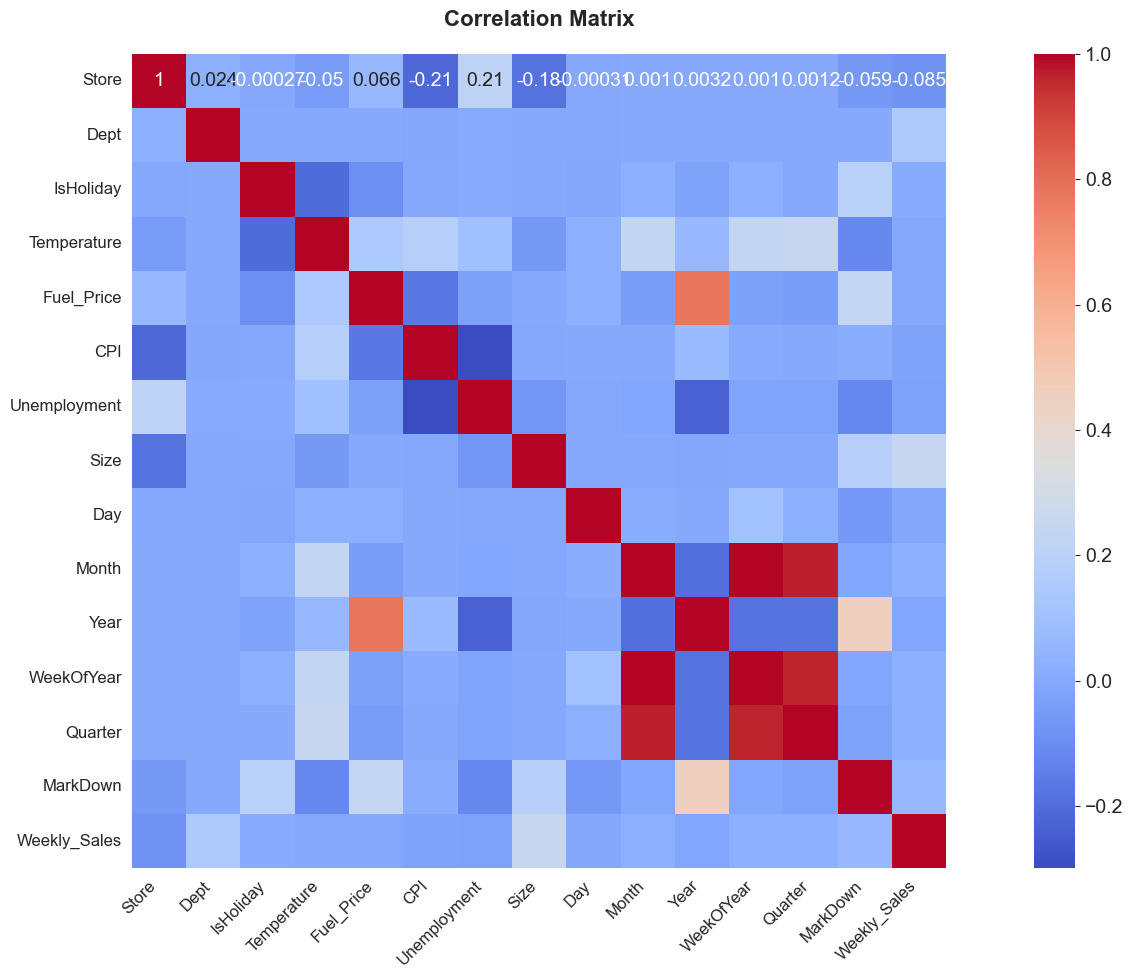

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter,MarkDown,Weekly_Sales
Store,1.00,0.02,-0.00,-0.05,0.07,-0.21,0.21,-0.18,-0.00,0.00,0.00,0.00,0.00,-0.06,-0.09
Dept,0.02,1.00,0.00,0.00,0.00,-0.01,0.01,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.15
IsHoliday,-0.00,0.00,1.00,-0.21,-0.09,-0.00,0.01,0.00,-0.01,0.03,-0.02,0.03,0.00,0.19,0.01
Temperature,-0.05,0.00,-0.21,1.00,0.14,0.18,0.10,-0.06,0.03,0.24,0.06,0.24,0.25,-0.11,-0.00
Fuel_Price,0.07,0.00,-0.09,0.14,1.00,-0.16,-0.03,0.00,0.03,-0.04,0.78,-0.03,-0.04,0.24,-0.00
CPI,-0.21,-0.01,-0.00,0.18,-0.16,1.00,-0.30,-0.00,0.00,0.00,0.07,0.01,0.00,0.02,-0.02
Unemployment,0.21,0.01,0.01,0.10,-0.03,-0.30,1.00,-0.07,-0.00,-0.01,-0.24,-0.02,-0.02,-0.12,-0.03
Size,-0.18,-0.00,0.00,-0.06,0.00,-0.00,-0.07,1.00,-0.00,0.00,-0.01,0.00,0.00,0.19,0.24
Day,-0.00,-0.00,-0.01,0.03,0.03,0.00,-0.00,-0.00,1.00,0.02,0.01,0.11,0.02,-0.06,-0.01
Month,0.00,0.00,0.03,0.24,-0.04,0.00,-0.01,0.00,0.02,1.00,-0.20,1.00,0.97,-0.01,0.03


In [323]:
# Calculate the correlation matrix
corr = train_data[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(18, 10))

sns.heatmap(corr, vmax=1.0, annot=True, cmap="coolwarm", square=True, ax=ax)
cmap = sns.color_palette("colorblind", as_cmap=True)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()


# Display the plot
plt.show()

# Set the threshold for multicollinearity
threshold = 0.7

# Create a styled table of the correlation matrix, this helps colorblind people to see the correlation values.
styled_corr = (
    corr.style.background_gradient(cmap="coolwarm", axis=None)
    .format("{:.2f}")
    .applymap(
        lambda x: "background-color: green" if abs(x) > threshold and x != 1.0 else ""
    )
)

# Display the styled table, this was added for the colorblind person in the group.  The table is easier to read.
display(styled_corr)

**Insights** - Size and Department seem to have the highest correlation with Weekly_Sales

What is the trend in sales through all the weeks of the year?

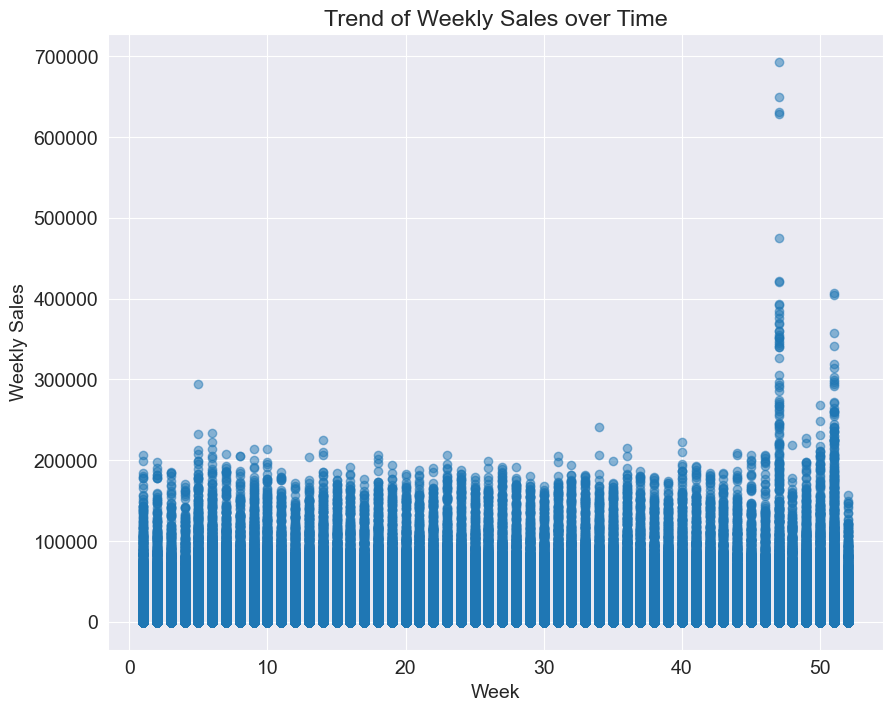

In [189]:
plt.scatter(train_data["WeekOfYear"], train_data["Weekly_Sales"], alpha=0.5)
plt.xlabel("Week")
plt.ylabel("Weekly Sales")
plt.title("Trend of Weekly Sales over Time")
plt.show()

**Insights** - There seems to be a major spike during Thanksgiving and Chrismas weeks

How does weekly sales look like for different stores?

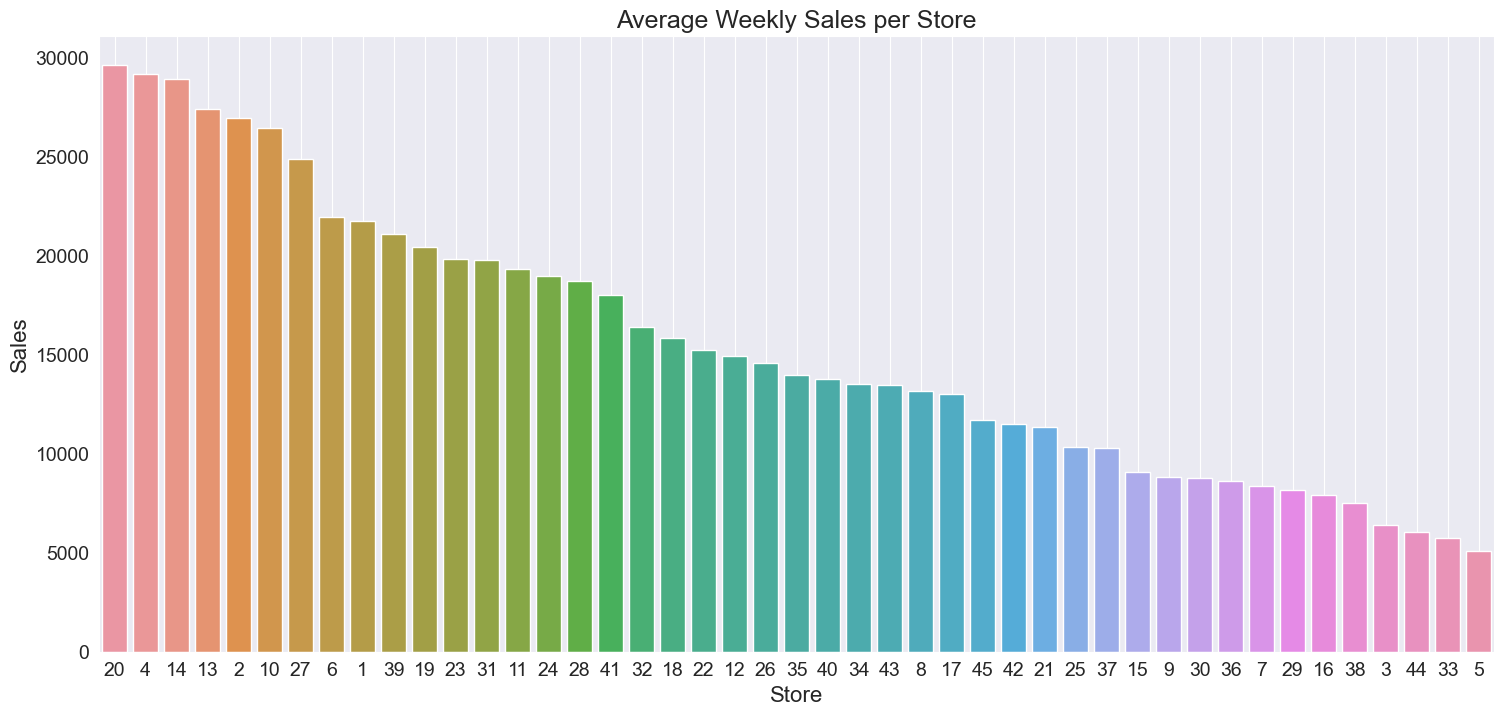

In [325]:
avg_sales_by_store = train_data.groupby("Store")["Weekly_Sales"].mean().reset_index()
plt.figure(figsize=(18, 8))
sns.barplot(x="Store", y="Weekly_Sales", data=avg_sales_by_store, order=avg_sales_by_store.sort_values("Weekly_Sales", ascending=False)["Store"])
plt.grid()
plt.title("Average Weekly Sales per Store", fontsize=18)
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Store", fontsize=16)
plt.savefig("plots/avg_sales_store.png")
plt.show()

**Insights** - The top 5 stores with high average weekly sales are 20,4,14,13,2, the data was annonomized so we do not know which store is which.

Does temperature have any impact on weekly sales?

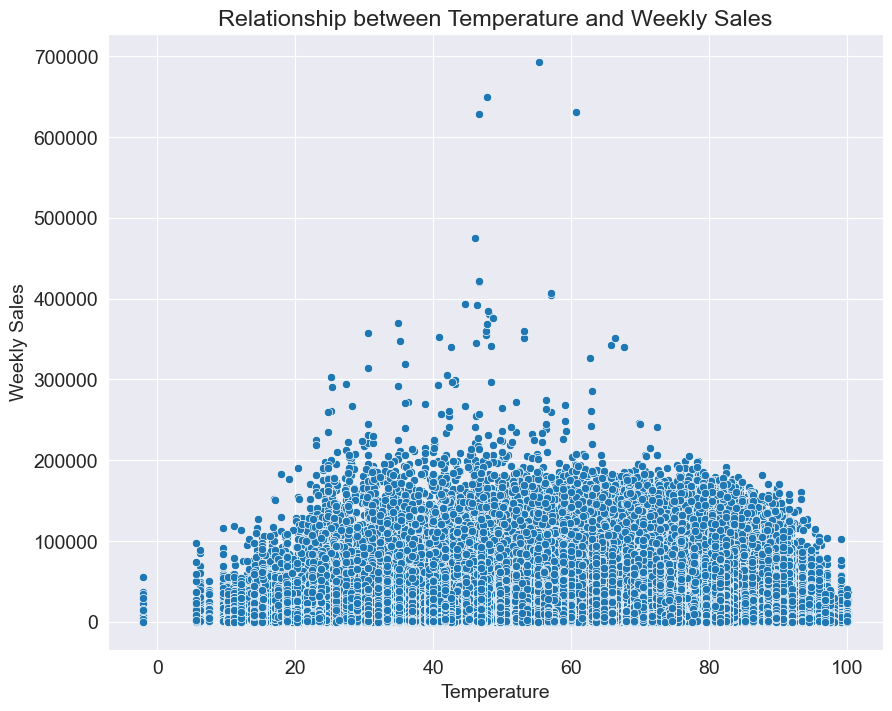

In [326]:
sns.scatterplot(data=train_data, x="Temperature", y="Weekly_Sales")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.title("Relationship between Temperature and Weekly Sales")
plt.show()

Does the store type show any impact on weekly sales?

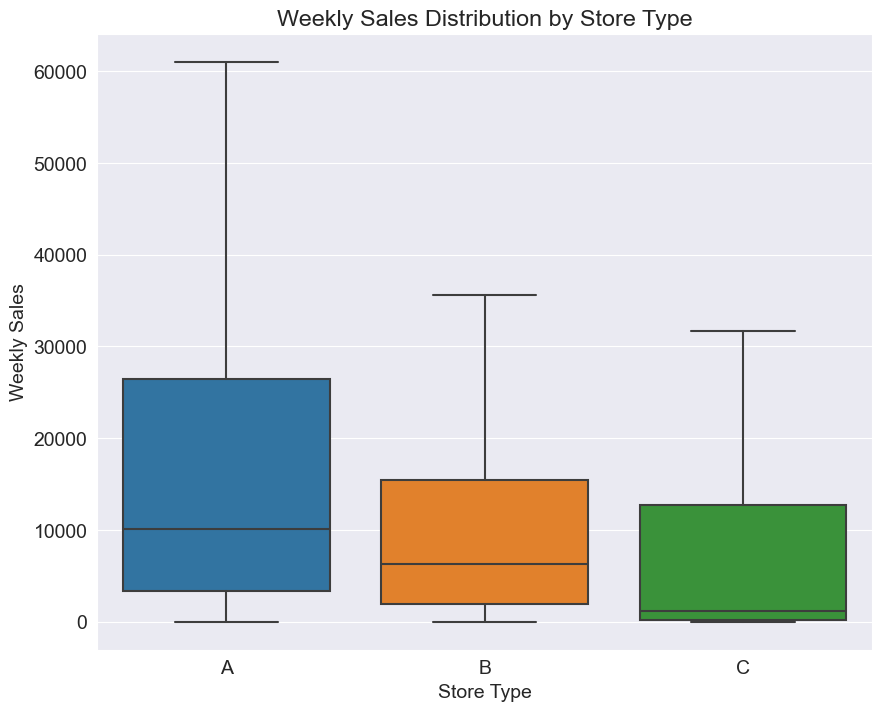

In [327]:
sns.boxplot(data=train_data, x="Type", y="Weekly_Sales", showfliers=False)
plt.xlabel("Store Type")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Distribution by Store Type")
plt.show()

**Insights** - Store type A has the highest average weekly sales

What is the average weekly sales by Month?

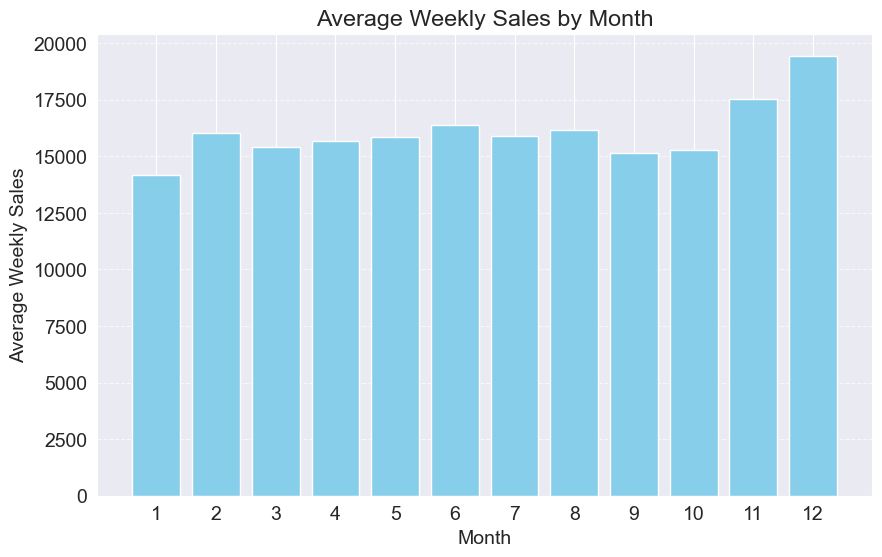

In [359]:

# Calculate the average weekly sales by month
avg_sales_by_month = train_data.groupby("Month")["Weekly_Sales"].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(
    avg_sales_by_month["Month"], avg_sales_by_month["Weekly_Sales"], color="skyblue"
)
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales by Month")
plt.xticks(avg_sales_by_month["Month"])  
plt.grid(axis="y", linestyle="--", alpha=0.7) 

plt.show()

November and December have the highest average weekly sales.

What is the relationship between the store size and weekly sales?

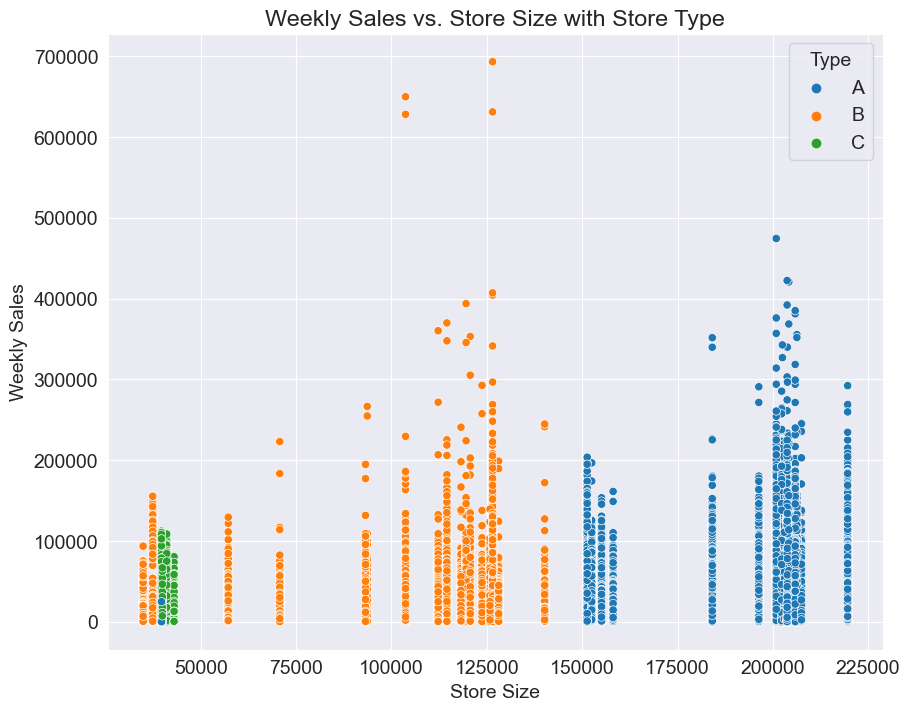

In [329]:
sns.scatterplot(data=train_data, x="Size", y="Weekly_Sales", hue="Type")
plt.xlabel("Store Size")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. Store Size with Store Type")
plt.show()

**Observation** - Store type A are bigger Walmarts and therefore it makes sense that they record highest weekly sales

Weekly sales for holiday vs. non-holiday weeks

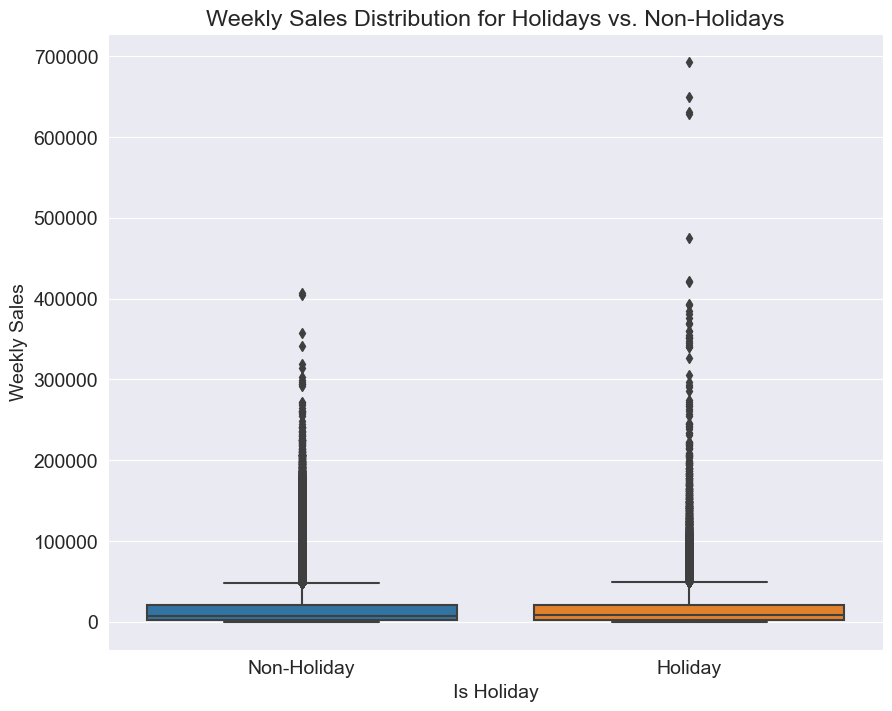

In [330]:
sns.boxplot(data=train_data, x="IsHoliday", y="Weekly_Sales")
plt.xlabel("Is Holiday")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Distribution for Holidays vs. Non-Holidays")
plt.xticks([0, 1], ["Non-Holiday", "Holiday"])
plt.show()

**Observation** - Holiday weeks have more high weekly sales outliers compared to non-holiday weeks

### Average weekly sales for all the years

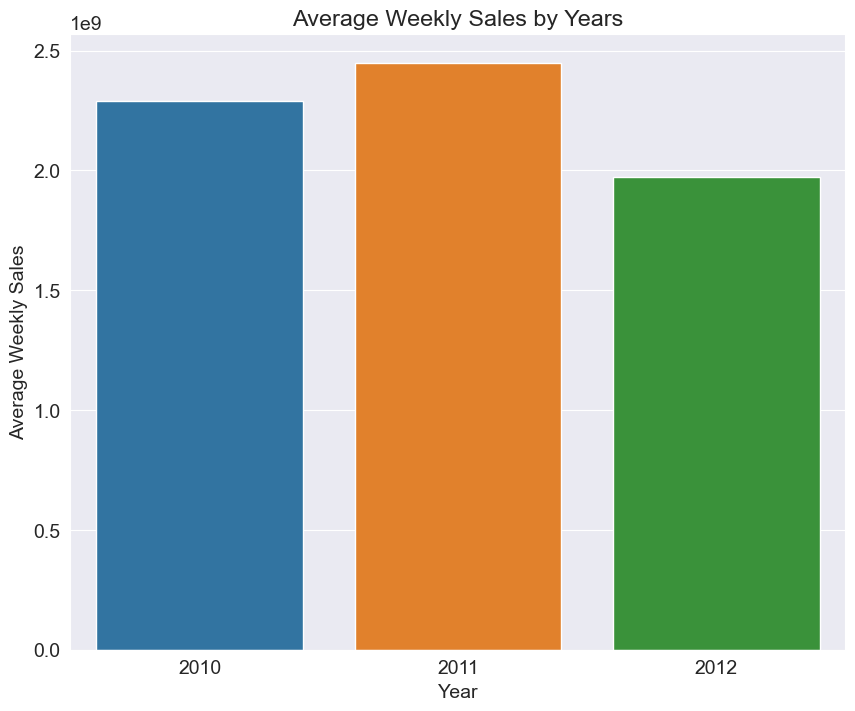

In [331]:
avg_sales_by_year = train_data.groupby("Year")["Weekly_Sales"].sum().reset_index()
# Plot the average weekly sales by years
sns.barplot(data=avg_sales_by_year, x="Year", y="Weekly_Sales")
plt.xlabel("Year")
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales by Years")
plt.show()

**Observation** - 2011 is the year that has recorded highest weekly sales

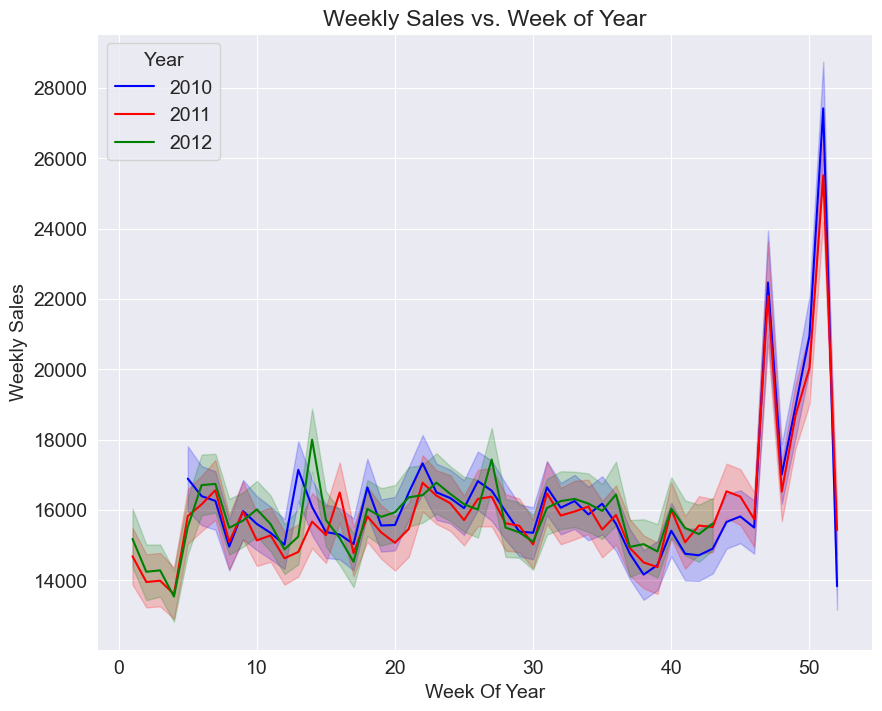

In [332]:
sns.lineplot(
    train_data,
    x="WeekOfYear",
    y="Weekly_Sales",
    hue="Year",
    palette=["blue", "red", "green"],
)
plt.xlabel("Week Of Year")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. Week of Year")
plt.show()

**Observation** - The yearly trends seem to follow similar sales trends - there are spikes around holiday weeks in November and December.

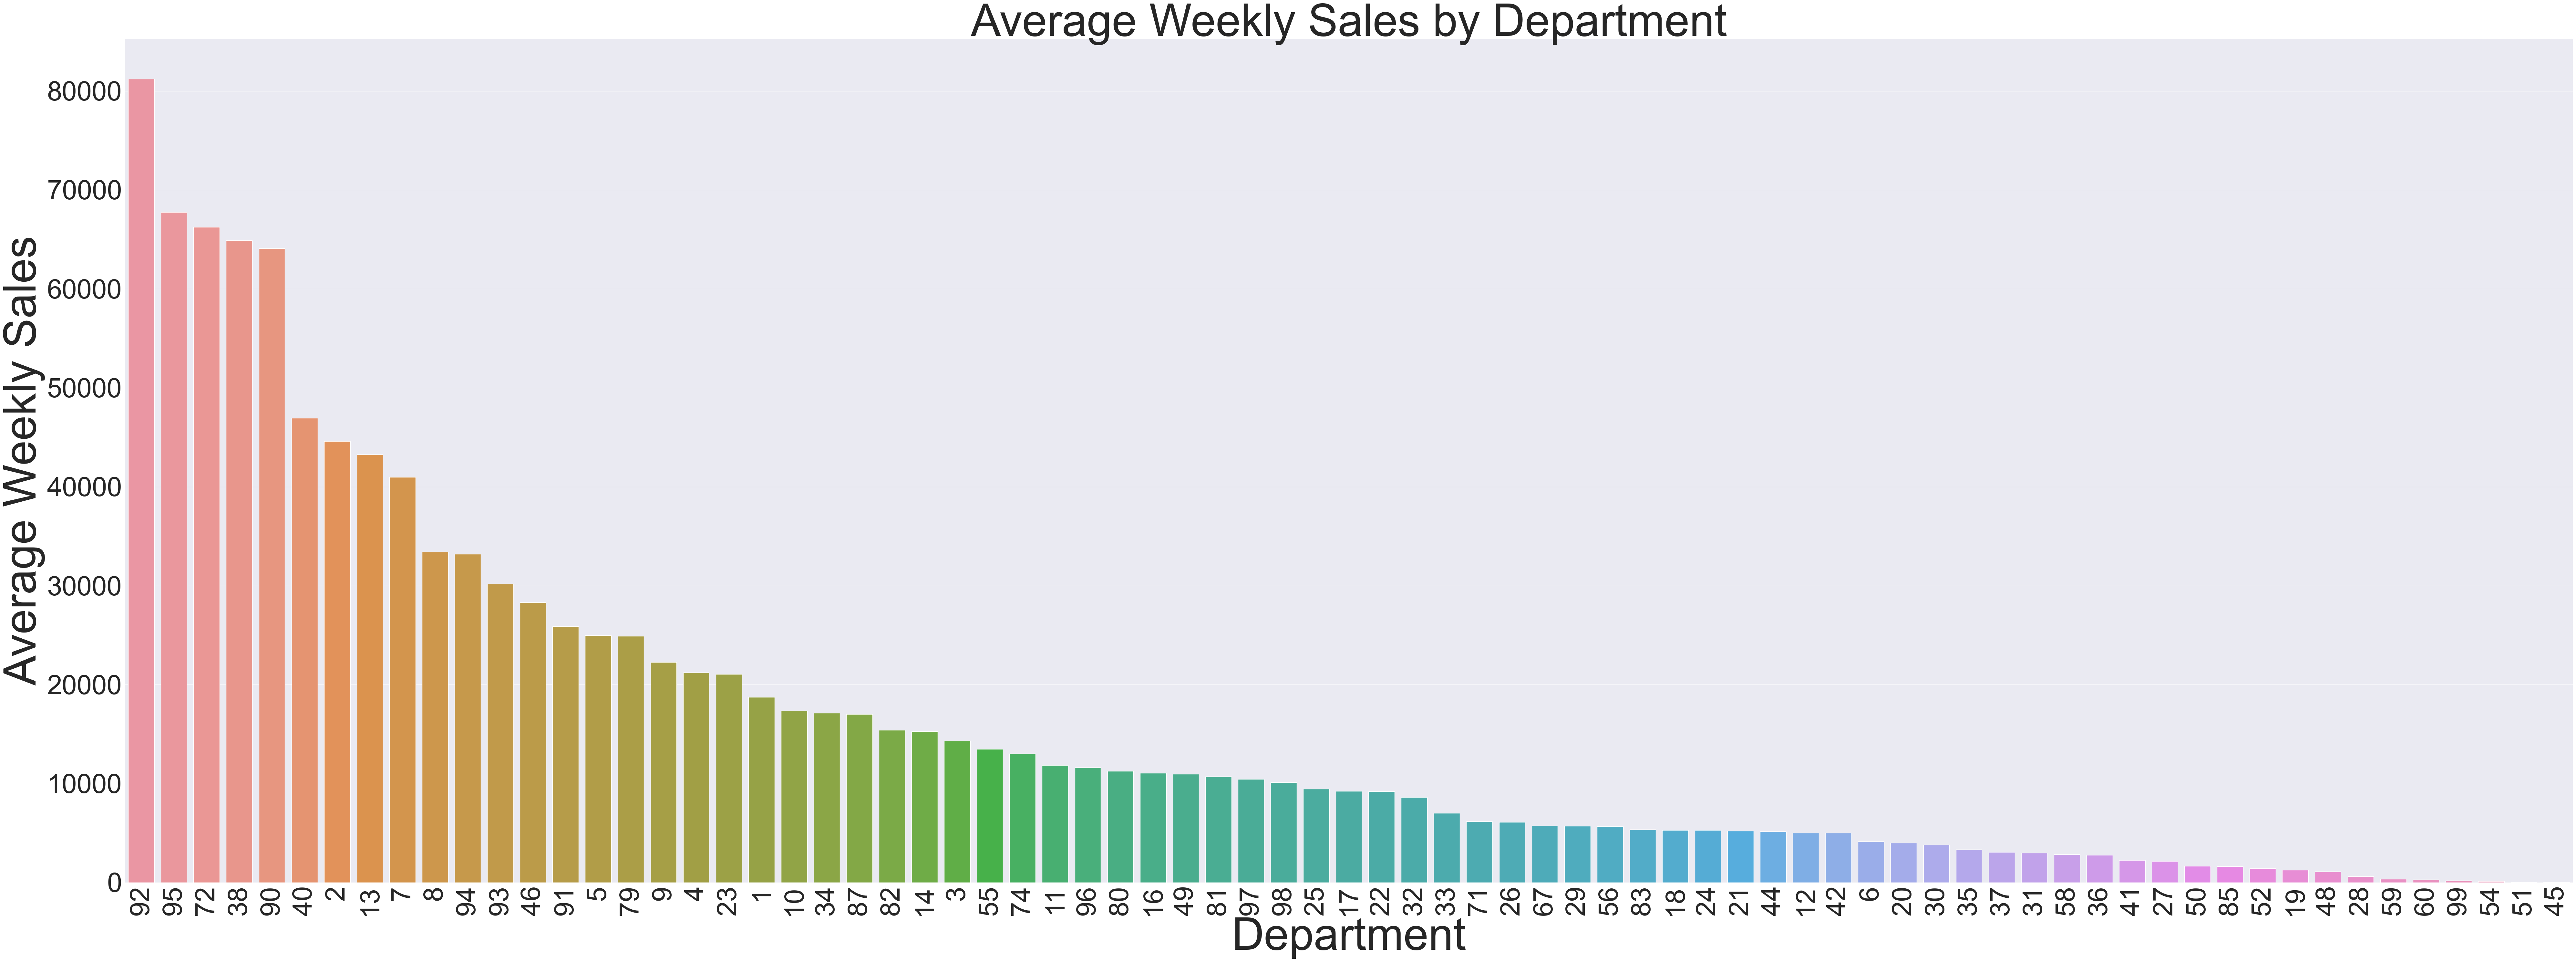

In [333]:
avg_sales_by_store = (
    train_data.sample(1000).groupby(["Dept"])["Weekly_Sales"].mean().reset_index()
)
plt.figure(figsize=(80, 30))
sns.barplot(
    data=avg_sales_by_store,
    x="Dept",
    y="Weekly_Sales",
    order=avg_sales_by_store.sort_values("Weekly_Sales", ascending=False)["Dept"],
)
plt.xlabel("Department", fontsize=100)
plt.ylabel("Average Weekly Sales", fontsize=100)
plt.title("Average Weekly Sales by Department", fontsize=100)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)
plt.xticks(rotation=90)  # Rotate X-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlapping
plt.show()

**Observation** - Store 92 has the highest average weekly sales, the store type is not known as the data is anonymized.

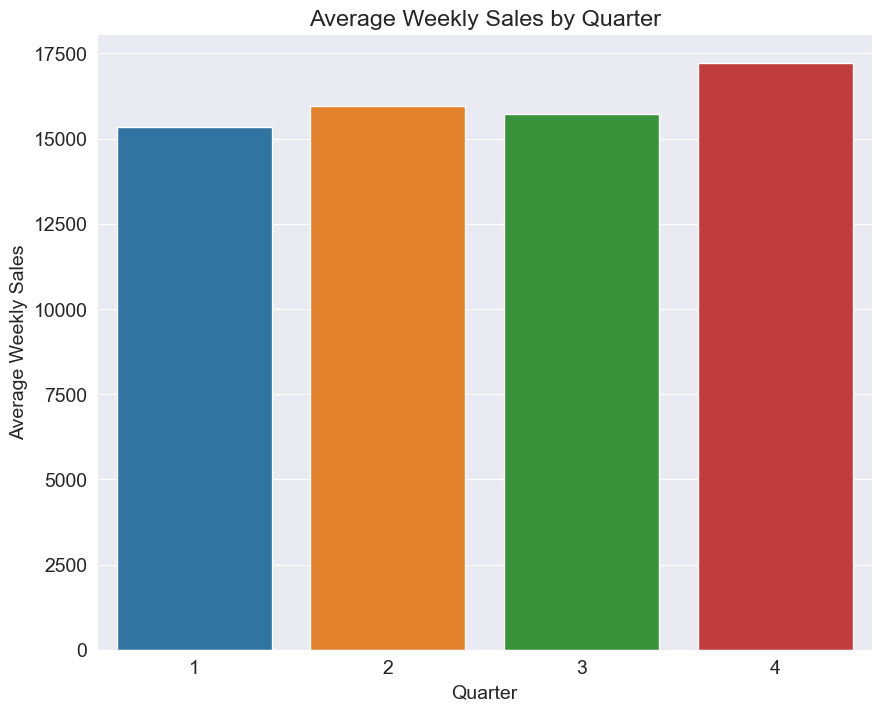

In [334]:
avg_sales_by_month = train_data.groupby("Quarter")["Weekly_Sales"].mean().reset_index()
sns.barplot(data=avg_sales_by_month, x="Quarter", y="Weekly_Sales")
plt.xlabel("Quarter")
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales by Quarter")
plt.show()

**Observation** - As expected, the 4th quarter (Black Friday and Christmas shopping) show more sales than the others

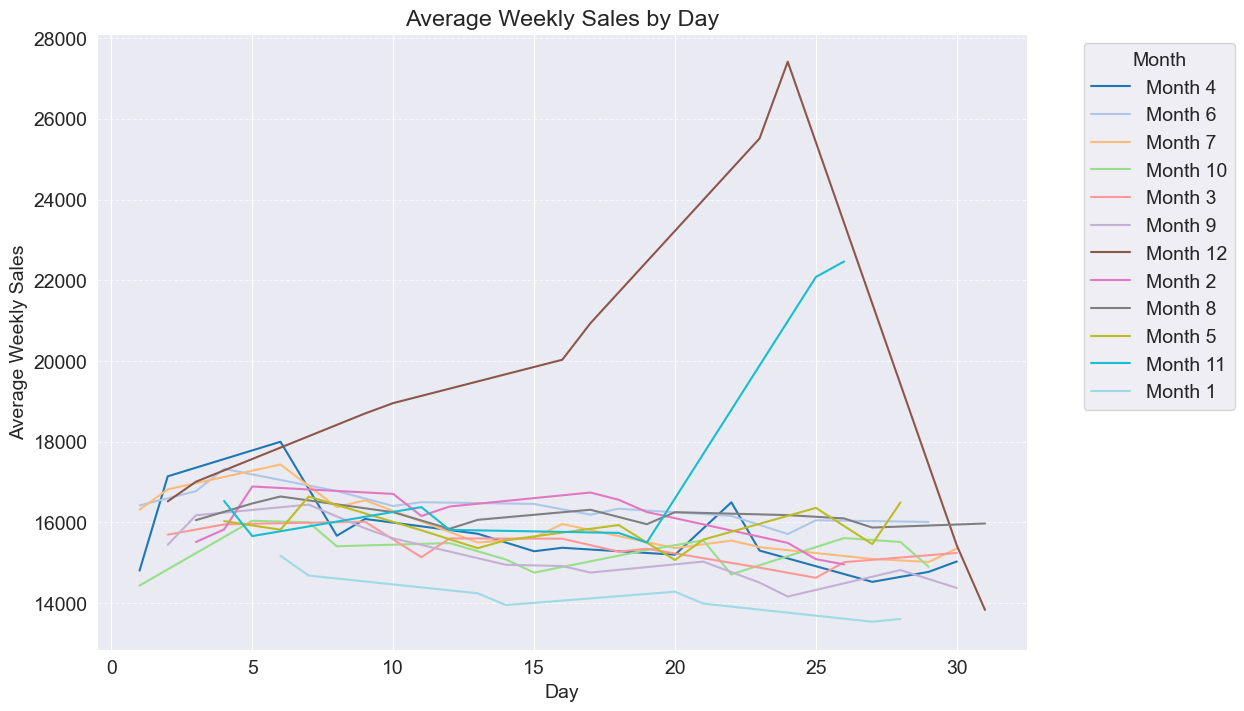

Month 12: Highest peak on Day 24 with sales of 27415.85
Month 11: Highest peak on Day 26 with sales of 22464.58
Month 4: Highest peak on Day 6 with sales of 17996.12
Month 7: Highest peak on Day 6 with sales of 17431.90
Month 6: Highest peak on Day 4 with sales of 17324.39
Month 2: Highest peak on Day 5 with sales of 16887.60
Month 8: Highest peak on Day 6 with sales of 16639.71
Month 5: Highest peak on Day 7 with sales of 16639.25
Month 9: Highest peak on Day 7 with sales of 16438.58
Month 10: Highest peak on Day 5 with sales of 16037.44
Month 3: Highest peak on Day 9 with sales of 16014.39
Month 1: Highest peak on Day 6 with sales of 15172.38


In [335]:

# Calculate the average weekly sales by day and month
avg_sales_by_day_month = (
    train_data.groupby(["Day", "Month"])["Weekly_Sales"].mean().reset_index()
)

# Create a colorblind-friendly color palette
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Initialize a list to store the highest peaks
highest_peaks = []

# Create the line plot using matplotlib
plt.figure(figsize=(12, 8))
for month, color in zip(avg_sales_by_day_month["Month"].unique(), colors):
    monthly_data = avg_sales_by_day_month[avg_sales_by_day_month["Month"] == month]
    plt.plot(
        monthly_data["Day"],
        monthly_data["Weekly_Sales"],
        label=f"Month {month}",
        color=color,
    )

    # Find the highest peak for the month
    max_sales = monthly_data["Weekly_Sales"].max()
    max_day = monthly_data[monthly_data["Weekly_Sales"] == max_sales]["Day"].values[0]
    highest_peaks.append((month, max_day, max_sales))

plt.xlabel("Day")
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales by Day")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Sort the highest peaks from highest to lowest sales
highest_peaks.sort(key=lambda x: x[2], reverse=True)

# Print the highest peaks
for month, day, sales in highest_peaks:
    print(f"Month {month}: Highest peak on Day {day} with sales of {sales:.2f}")

**Insights** - Decmber 24th has the highest weekly sales, followed by November 26th (Black Friday)

### Step 3 Prepping the data to train the model.

In [210]:
train_df, val_df = train_test_split(train_data, test_size=0.25, random_state=42)

In [211]:
len(train_df), len(val_df)

(313990, 104664)

### Identifying Inputs, "input_cols   Target Column "target_col" Weekly_Sales is the target column.

In [212]:
input_cols = [
    "Store",
    "Dept",
    "IsHoliday",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Type",
    "Size",
    "Day",
    "Month",
    "Year",
    "WeekOfYear",
    "Quarter",
    "MarkDown",
]
target_col = "Weekly_Sales"

input_cols: List of column names representing the input features used to train the model.
target_col: The name of the column representing the target variable  "Weekly_Sales".
train_inputs = train_df[input_cols].copy(): This line selects the columns specified in input_cols from train_df (the DataFrame containing the training data) and makes a copy of them. These are the features that will be used to train the model.
train_targets = train_df[target_col].copy(): This line selects the column specified in target_col from train_df and makes a copy of it. This is the target variable that the model will learn to predict.
val_inputs = val_df[input_cols].copy(): Similar to the training data, this line selects and copies the input feature columns from val_df (the DataFrame containing the validation data). The validation data is used to evaluate the model's performance during the training process.
val_targets = val_df[target_col].copy(): This line selects and copies the target variable from val_df.

train_inputs and train_targets: Input features and target variable for training the model.
val_inputs and val_targets: Input features and target variable for validating the model's performance during training.
test_inputs: Input features for making predictions with the trained model.

In [336]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_data[input_cols].copy()

### Identifying numeric and categorical columns.
return numeric_cols, categorical_cols: This line returns two lists: numeric_cols and categorical_cols. These lists contain the names of the numeric and categorical columns, respectively.
.columns.tolist(): This converts the index of the selected columns to a list of column names.

In [337]:
def num_cat_cols(data):
    numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = data.select_dtypes("object").columns.tolist()

    return numeric_cols, categorical_cols

### Identifying numeric and categorical columns.

In [338]:
numeric_cols, categorical_cols = num_cat_cols(train_inputs)

### Imputation
Inputer is used to handle missing values in numeric columns of the dataset.
SimpleImputer: A class from sklearn.impute used to handle missing values in a dataset.
strategy="mean": Specifies that missing values should be replaced with the mean of the column.
.fit(): Calculates the mean of each column in the training data.
.transform(): Replaces missing values with the mean values calculated during the fitting step.
train_inputs, val_inputs, test_inputs: DataFrames containing the training, validation, and test data, respectively.  This ensures that the imputation is consistent across all datasets and helps in maintaining the integrity of the data for model training and evaluation.


In [339]:
# Imputation
imputer = SimpleImputer(strategy="mean").fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

### Scaling 
MinMaxScaler: A class from sklearn.preprocessing used to scale features to a specified range, typically 0 to 1.
.fit(): Calculates the minimum and maximum values for each numeric column in the training data.
.transform(): Scales the numeric columns to be within the specified range based on the calculated minimum and maximum values.
train_inputs, val_inputs, test_inputs: DataFrames containing the training, validation, and test data, respectively.
numeric_cols: A list of column names representing the numeric features in the dataset.

In [340]:
# Scaling
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encoding. 
sparse_output=False: Specifies that the output should be a dense array.
handle_unknown="ignore": Ignores unknown categories encountered during transformation.
.fit(): Learns the unique categories for each categorical column in the training data.
.get_feature_names_out(): Retrieves the names of the new columns created by the one-hot encoding process.
.transform(): Applies the learned encoding to the categorical columns, transforming them into one-hot encoded columns.
train_inputs, val_inputs, test_inputs: DataFrames containing the training, validation, and test data, respectively.
categorical_cols: A list of column names representing the categorical features in the dataset.
encoded_cols: A list of new column names generated by the one-hot encoding process.

In [341]:
# Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore").fit(
    train_inputs[categorical_cols]
)
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

numeric_cols: A list of column names representing the numeric features in the dataset.
encoded_cols: A list of new column names generated by the one-hot encoding process for categorical features.
train_inputs, val_inputs, test_inputs: DataFrames containing the training, validation, and test data, respectively, with numeric and categorical features.
X_train: The combined DataFrame of numeric and one-hot encoded categorical features for training.
X_val: The combined DataFrame of numeric and one-hot encoded categorical features for validation.
X_test: The combined DataFrame of numeric and one-hot encoded categorical features for testing.

In [342]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

### 4. Implement and Train ML models
Baseline Model - Linear Regression models using LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor.

In [267]:
#Showing this to provide reference and context for the baseline Linear Regression model.
weekly_sales_summary = train_data["Weekly_Sales"].describe()
print(weekly_sales_summary)

count    418654.000000
mean      16028.664965
std       22726.308043
min           0.010000
25%        2118.287500
50%        7659.405000
75%       20267.445000
max      693099.360000
Name: Weekly_Sales, dtype: float64


In [343]:
linear_models_scores = {}

In [344]:
def try_linear_models(model_name, model):
    model.fit(X_train, train_targets)  # training the model on training data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)  # model predictions on validation data

    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)

    linear_models_scores[model_name] = {
        "mae": [round(train_mae, 2), round(val_mae, 2)],
        "rmse": [round(train_rmse, 2), round(val_rmse, 2)],
        "r2": [round(train_r2, 2), round(val_r2, 2)],
    }

    return val_mae, val_rmse, val_r2

In [345]:
# Define Model Names and Instances
model_names = ["linear", "ridge", "lasso", "elasticnet", "sgd"]
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]

# Iterate Over Models and Evaluate
for model_name, model in zip(model_names, models):
    val_mae, val_rmse, val_r2 = try_linear_models(model_name, model)
    print(f"Model: {model_name}")
    print(f"Validation MAE: {val_mae}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Validation R2: {val_r2}")
    print("**********")

Model: linear
Validation MAE: 14552.108231674692
Validation RMSE: 21612.421356707677
Validation R2: 0.08818554181515426
**********
Model: ridge
Validation MAE: 14551.676726750353
Validation RMSE: 21611.823153355224
Validation R2: 0.08823601676268777
**********
Model: lasso
Validation MAE: 14550.866532931243
Validation RMSE: 21611.819732648568
Validation R2: 0.08823630538959859
**********
Model: elasticnet
Validation MAE: 14783.65085787188
Validation RMSE: 22160.29303492402
Validation R2: 0.04137087343008139
**********
Model: sgd
Validation MAE: 14639.43980811534
Validation RMSE: 21614.575559262157
Validation R2: 0.08800376385567699
**********


# Mean Absolute Error (MAE):
Definition: The average of the absolute differences between the predicted values and the actual values.
Interpretation: Lower MAE indicates better model performance as it shows that the predictions are close to the actual values on average.

# Root Mean Squared Error (RMSE):
Definition: The square root of the average of the squared differences between the predicted values and the actual values.
Interpretation: Lower RMSE indicates better model performance. RMSE gives more weight to larger errors compared to MAE due to squaring the differences, making it more sensitive to outliers.

# R-squared (R²):
Definition: The proportion of the variance in the dependent variable that is predictable from the independent variables.
Interpretation: R² ranges from 0 to 1. Higher R² indicates better model performance, meaning a larger proportion of variance is explained by the model. An R² of 1 means the model perfectly predicts the target variable, while an R² of 0 means the model does not explain any variance.

We see that the linear models on average returns RMSE scores of ~$21,000. This is a very poor performance by our baseline ML models as ~21,000 is around the 75th percentile of weekly sales. The model r2 score is very low and therefore we do not find it necessary to use the linear models further.

Our analysis reveals that the performance of the linear models falls short of our expectations, with an average Root Mean Squared Error (RMSE) of approximately $21,000. To put this into perspective, this margin of error is equivalent to the 75th percentile of our weekly sales figures. Such a significant discrepancy between the predicted and actual values raises concerns about the reliability and practicality of these baseline machine learning models in our business context.

Training the Model: The function fits the provided model to the training data.
Making Predictions: The function makes predictions on both training and validation datasets.
Calculating Scores: The function calculates the mean absolute error (MAE), root mean squared error (RMSE), and R-squared (R²) scores for both the training and validation datasets.
Storing Scores: The function stores the calculated scores in the provided score_dict dictionary, making it easy to access and compare the performance metrics for different models.
This function helps in systematically training and evaluating different ensemble methods and capturing their performance metrics, which can be useful for model comparison and selection.

## Esemble Models - Random Forest, Gradient Boosting,and XGBoost.
ensemble_models: A list of three ensemble model instances.
ensemble_model_names: A list of names corresponding to the models in ensemble_models.
score_dicts: A list of dictionaries to store the evaluation metrics for each model.
for loop: Iterates over the three models, calling the try_ensemble_methods function to train and evaluate each model, and prints the validation metrics.

In [346]:
rf_scores = {}  # Random Forest
gb_scores = {}  # Gradient Boosting
xgb_scores = {}  # XGBoost
trained_models = {}

In [347]:
def try_ensemble_methods(model_name, model, score_dict):

    model.fit(X_train, train_targets.values.ravel())

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)

    score_dict["mae"] = {
        "training": round(train_mae, 2),
        "validation": round(val_mae, 2),
    }
    score_dict["rmse"] = {
        "training": round(train_rmse, 2),
        "validation": round(val_rmse, 2),
    }
    score_dict["r2"] = {"training": round(train_r2, 2), "validation": round(val_r2, 2)}

    trained_models[model_name] = model

    return val_mae, val_rmse, val_r2

### To compare apples to apples we used the same random_state and N-jobs (where applicable) for all the models.

In [348]:
# Define Model Names, Instances, and Score Dictionaries
ensemble_models = [
    RandomForestRegressor(random_state=42, n_jobs=-1),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42, n_jobs=-1),
]
ensemble_model_names = ["random_forest", "gradient_boosting", "xgboost"]
score_dicts = [rf_scores, gb_scores, xgb_scores]

# Iterate Over Models and Evaluate
for model_name, model, score_dict in zip(
    ensemble_model_names, ensemble_models, score_dicts
):
    val_mae, val_rmse, val_r2 = try_ensemble_methods(model_name, model, score_dict)
    print("*********")
    print(f"Model: {model_name}")
    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Validation R2: {val_r2:.2f}")

print ("***Model Evaluation Completed with the following results.***")
print("Random Forest scores")
display(pd.DataFrame(rf_scores))
print("XGBoost Scores")
display(pd.DataFrame(xgb_scores))
print("Gradient Boosting Scores")
display(pd.DataFrame(gb_scores))

*********
Model: random_forest
Validation MAE: 1334.63
Validation RMSE: 3509.05
Validation R2: 0.98
*********
Model: gradient_boosting
Validation MAE: 6841.50
Validation RMSE: 11637.06
Validation R2: 0.74
*********
Model: xgboost
Validation MAE: 2978.43
Validation RMSE: 5361.71
Validation R2: 0.94
***Model Evaluation Completed with the following results.***
Random Forest scores


,mae,rmse,r2
training,492.84,1236.34,1.00
validation,1334.63,3509.05,0.98


XGBoost Scores


,mae,rmse,r2
training,2914.42,5050.63,0.95
validation,2978.43,5361.71,0.94


Gradient Boosting Scores


,mae,rmse,r2
training,6852.49,11590.97,0.74
validation,6841.50,11637.06,0.74


### Feature importance for each model.

In [349]:
rf = trained_models["random_forest"]
xgb = trained_models["xgboost"]
gb = trained_models["gradient_boosting"]

<Axes: title={'center': 'Feature Importance Random Forest'}, xlabel='importance', ylabel='feature'>

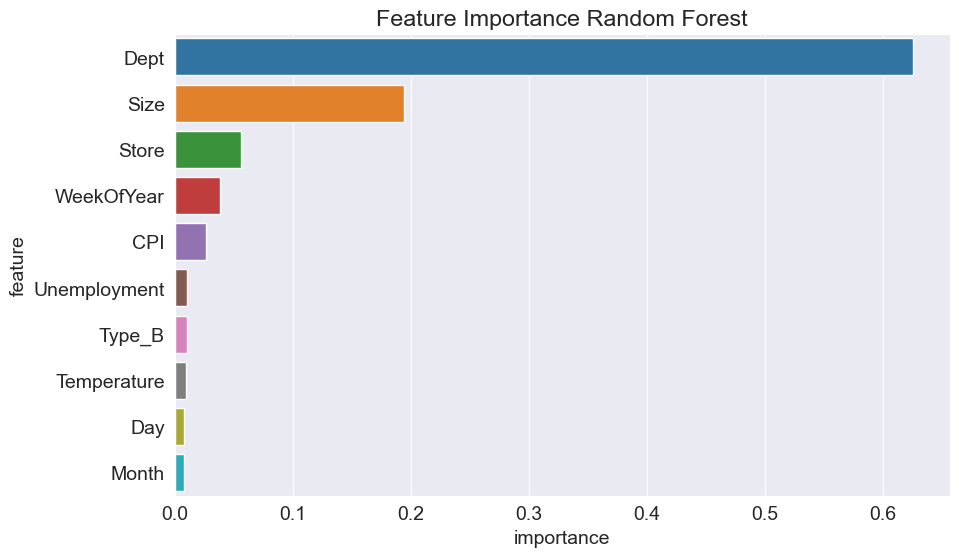

In [350]:
rf_imp_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance Random Forest")
sns.barplot(data=rf_imp_df.head(10), x="importance", y="feature")

<Axes: title={'center': 'Feature Importance XGBoost'}, xlabel='importance', ylabel='feature'>

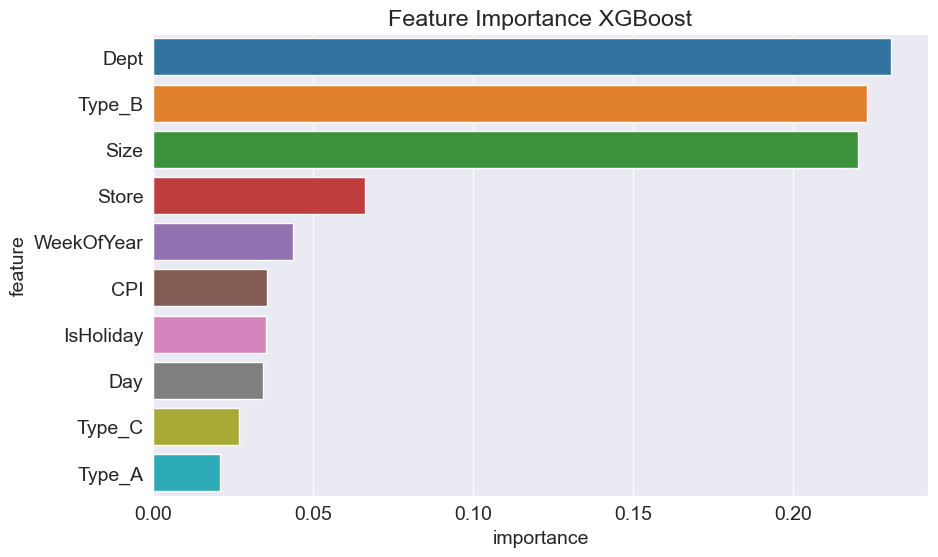

In [351]:
xgb_imp_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": xgb.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance XGBoost")
sns.barplot(data=xgb_imp_df.head(10), x="importance", y="feature")

<Axes: title={'center': 'Feature Importance Gradient Boosting'}, xlabel='importance', ylabel='feature'>

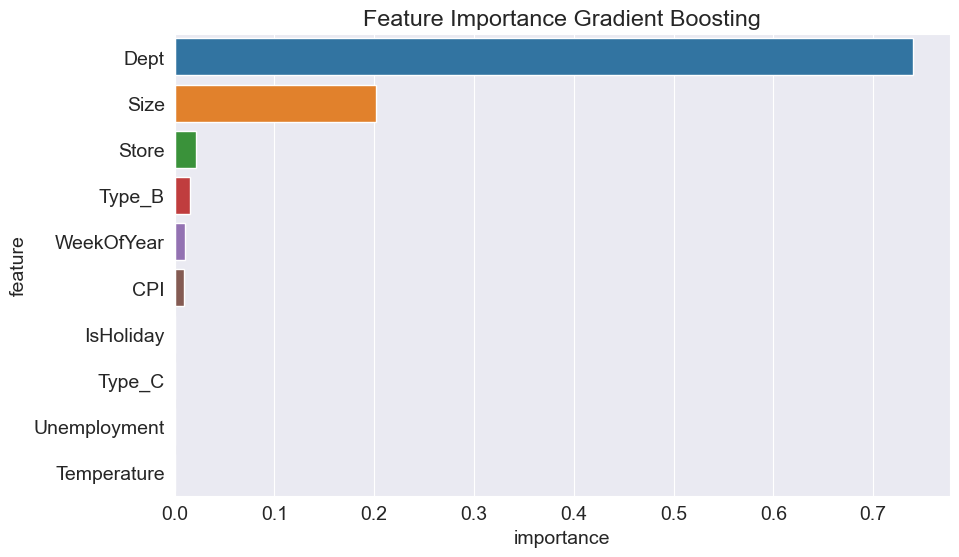

In [353]:
gb_imp_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": gb.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance Gradient Boosting")
sns.barplot(data=gb_imp_df.head(10), x="importance", y="feature")

Dept and Size are the two most important features that determine weekly sales

# 6. Hyperparameter Tuning

train_weights: An array that assigns a weight of 5 to training samples that occur on holidays and a weight of 1 to those that do not.
val_weights: An array that assigns a weight of 5 to validation samples that occur on holidays and a weight of 1 to those that do not.
Why Assign Weights?
Emphasize Important Samples: By assigning higher weights to holiday samples, we emphasize the importance of accurately predicting sales during holidays. Holidays may have significantly different sales patterns compared to regular days.
Balanced Learning: Because the holidays are less frequent in the dataset, weighting helps in ensuring that the model does not underfit the holiday samples due to their minority status.

In [360]:
# Creating the weights
train_weights = np.where(X_train["IsHoliday"] == 1, 5, 1)
val_weights = np.where(X_val["IsHoliday"] == 1, 5, 1)

In [357]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [366]:
models = {
    "randomforest": {
        "model": RandomForestRegressor,
        "params": {
            "max_depth": [5, 10, 15, 20, 25],
            "n_estimators": [20, 50, 200, 250],
            "min_samples_split": [2, 4, 5, 10],
        },
    },
    "xgboost": {
        "model": XGBRegressor,
        "params": {
            "max_depth": [3, 4, 6, 8, 9, 10],
            "n_estimators": [30, 50, 200, 250],
            "learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001],
        },
    },
}

In [367]:
results = {}

def test_params(model_type, model, **params):
    model_instance = model(**params)
    model_instance.fit(X_train, train_targets)
    train_wmae = weighted_mean_absolute_error(
        model_instance.predict(X_train), train_targets, train_weights
    )
    val_wmae = weighted_mean_absolute_error(
        model_instance.predict(X_val), val_targets, val_weights
    )

    return train_wmae, val_wmae


def test_param_and_plot(model_type, model, param_name, param_values):

    train_errors, val_errors = [], []
    wmae_results = {}

    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(model_type, model, **params)

        train_errors.append(train_wmae)
        val_errors.append(val_wmae)

    plt.figure(figsize=(10, 6))
    plt.title(model_type + " Overfitting curve: " + param_name)
    plt.plot(param_values, train_errors, "b-o")
    plt.plot(param_values, val_errors, "r-o")
    plt.xlabel(param_name)
    plt.ylabel("WMAE")
    plt.legend(["Training", "Validation"])

    wmae_results[param_name] = {"train_wmae": train_errors, "val_wmae": val_errors}

    return wmae_results

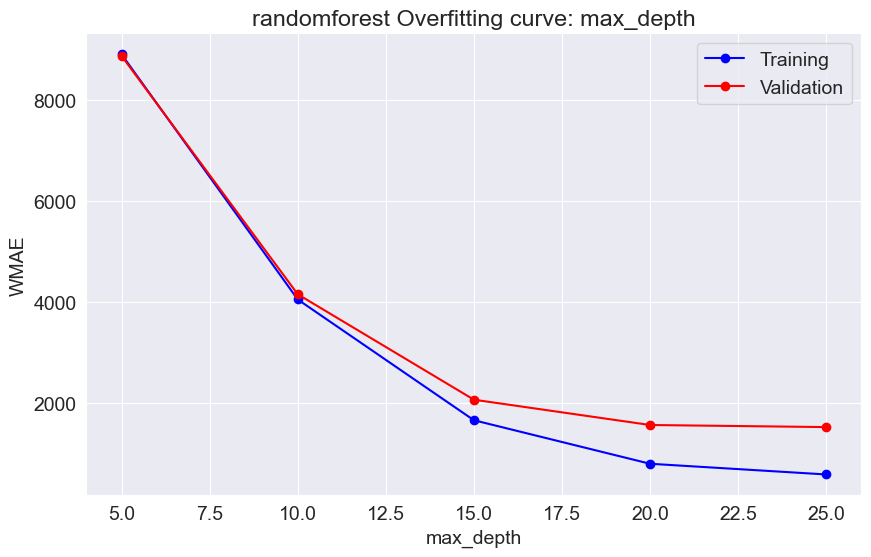

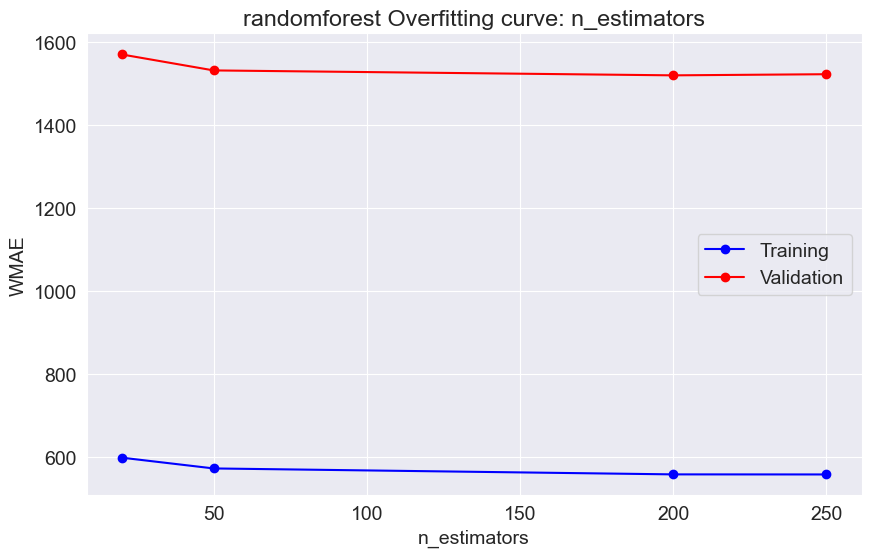

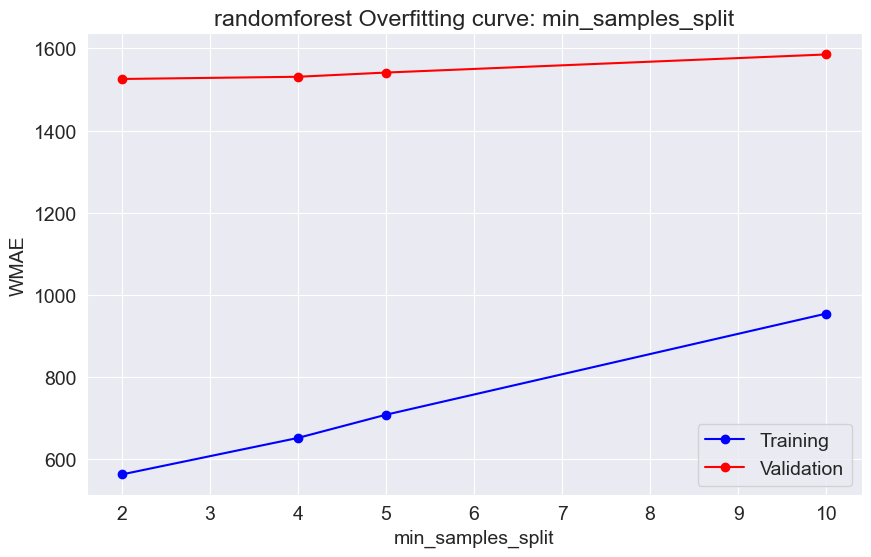

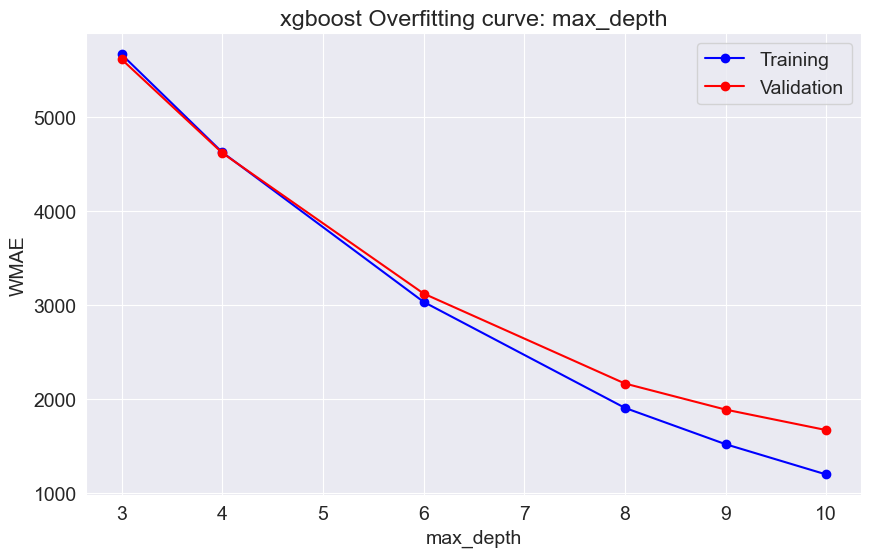

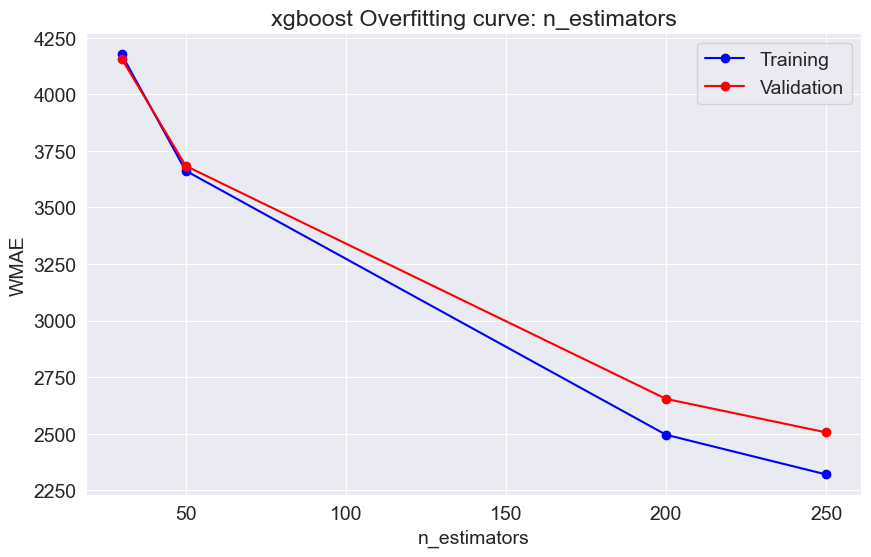

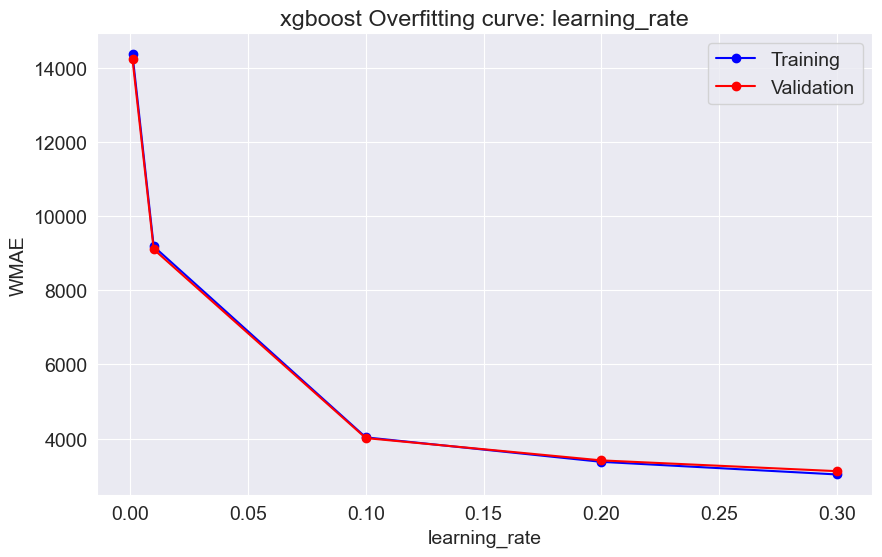

In [369]:
 #Iterate over each model type
for model_type, config in models.items():
    model = config['model']
    params = config['params']
    
    # Iterate over each parameter and its values
    for param_name, param_values in params.items():
        wmae_results = test_param_and_plot(model_type, model, param_name, param_values)
        results[model_type] = wmae_results

In [373]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [374]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "n_estimators": [200],
    "max_depth": [8],
    "min_samples_split": [5],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, train_targets)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Calculate cross-validation scores for WMAE and R²
wmae_scorer = make_scorer(weighted_mean_absolute_error, greater_is_better=False)
wmae_scores = -cross_val_score(
    best_model, X_train, train_targets, cv=5, scoring=wmae_scorer
)

r2_scores = cross_val_score(best_model, X_train, train_targets, cv=5, scoring="r2")


# Print R² scores
print("Cross-validation R² scores: ", r2_scores)
print("Mean R²: ", np.mean(r2_scores))

# Fit the best model on the training data
best_model.fit(X_train, train_targets)

# Calculate and print the validation WMAE
print("Validation WMAE")
rf_val_wmae = weighted_mean_absolute_error(
    val_targets, best_model.predict(X_val), val_weights
)
print("Validation WMAE: ", rf_val_wmae)

# Calculate and print the validation R² score
val_r2 = r2_score(val_targets, best_model.predict(X_val))
print("Validation R²: ", val_r2)

Cross-validation R² scores:  [0.82449154 0.82011004 0.82444647 0.8219284  0.82087204]
Mean R²:  0.8223696970892789
Validation WMAE
Validation WMAE:  5727.941440407421
Validation R²:  0.8105358134417442
